## TMD implementation


### 1. get a tree;
 - [x] skeleton; max inscribed ball; katere so hitre implementacije?
 - [x] find the two starting points of the trees 
 - [x] follow the skeleton from souce, calc arclen as you go and save all branch points


In [747]:
import numpy as np 
import matplotlib.pyplot as plt
import cc3d
import nrrd
import time
from skimage.morphology import skeletonize, medial_axis, thin, cube, ball, octahedron
from pathlib import Path
from scipy.ndimage import correlate

imgpath = Path("/home/maia-user/Desktop/nnUNet_raw/Dataset666_ASOCA/imagesTr")
labelpath = Path("/home/maia-user/Desktop/nnUNet_raw/Dataset666_ASOCA/labelsTr/")

#### Image loading

In [748]:
# which img
tip, nr = "N", 11

#load img and label
imname = f"{'Diseased' if tip=='D' else 'Normal'}_{nr}"
img, headimg = nrrd.read(Path(imgpath, f"{imname}_0000.nrrd" ))
label, headlab = nrrd.read(Path(labelpath, imname+".nrrd"))

#### Handling each main CC separately

In [749]:
# separate to two CCs, analyse each separately. Discard all but smallest two
start = time.time()
labels_out, N = cc3d.connected_components(label, connectivity=26, return_N=True)
#labels_out = cc3d.largest_k(labels_out, k=2, connectivity=26, delta=0)
stats = cc3d.statistics(labels_out)
time_cc3d = time.time()-start #0.3945
print("found", N, "connected components!")

found 2 connected components!


In [750]:

labels_out, N = cc3d.connected_components(label, connectivity=26, return_N=True)
stats = cc3d.statistics(labels_out)
mainCCs = np.argsort(stats['voxel_counts'])[-3:-1]
# Now you have the indices of two main vascular CCs. 
# The first one is smaller in size than the second one, by construction.
# Which is left, which is right:
cc1 = stats['bounding_boxes'][mainCCs[0]]
cc2 = stats['bounding_boxes'][mainCCs[1]]
if cc1[0].start>cc2[0].start:
    L, R = mainCCs[0], mainCCs[1]
  #  Lroot, Rroot = cc1[2].stop, cc2[2].stop
    bbL, bbR = cc1, cc2
else:
    L, R = mainCCs[1], mainCCs[0]
  #  Lroot, Rroot = cc2[2].stop, cc1[2].stop
    bbL, bbR = cc2, cc1

# for faster processing, cut the image to bounding box+1. 
bbL = tuple(slice(max(ind.start-1, 0),  min(ind.stop+1, s), None) for ind, s in zip(bbL, label.shape))
bbR = tuple(slice(max(ind.start-1, 0),  min(ind.stop+1, s), None) for ind, s in zip(bbR, label.shape))

CCdict = {'left': (bbL, stats['voxel_counts'][L], labels_out[*bbL]==L), 'right': (bbR, stats['voxel_counts'][R], labels_out[*bbR]==R)}

# OBS! this root (L/Rroot) is not really well defined, due to possible arches at/near ostia! But for this purpose it should be fine. 
CCdict = getCCinfo(label)

#### Get topological skeleton

In [751]:
#choose one vesseltree
side = 'left'
vessel1 = CCdict[side][-1]

# centerline, thinning, medial axis
#start = time.time()
#skel_medax, distance_out = medial_axis(vessel, return_distance=True) # ONLY FOR 2D!
#Tma = time.time()-start

start = time.time()
skel_base1 = skeletonize(vessel1)
Tbs = time.time()-start

#start = time.time()
#skel_thin = thin(vessel) # ONLY FOR 2D!
#Tth = time.time()-start

side = 'right'
vessel2 = CCdict[side][-1]
skel_base2 = skeletonize(vessel2)

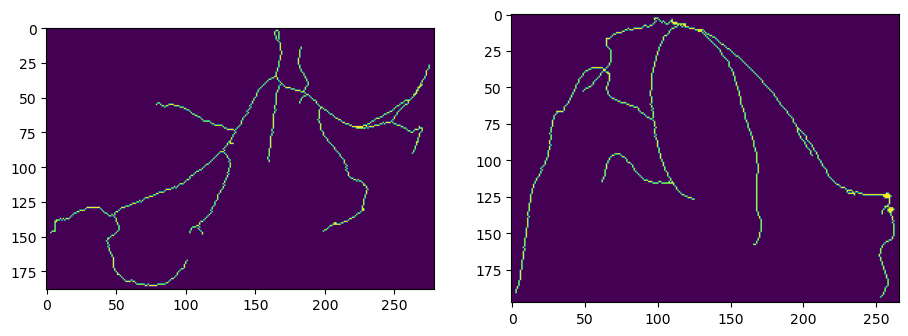

In [752]:
plt.figure(figsize=(11, 5))
plt.subplot(1,2,1)
plt.imshow(skel_base1.max(axis=2))
plt.subplot(1,2,2)
plt.imshow(skel_base2.max(axis=2))
#plt.imshow(img[:,:, 223]) # y: 0=prsi, N=hrbet, x:L-D ali D-L, z: 0=spodaj/noge, N=zgoraj/glava

#### Find root, leaves and bifurcations

More than one candidate for root (L)!
More than one candidate for root (R)!


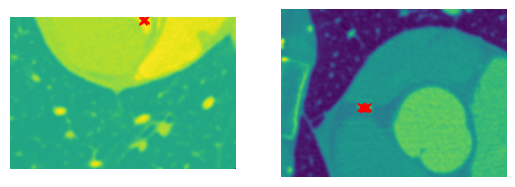

0.04974222183227539


In [753]:
#find actual source in the skeleton: since skeleton is supposedly 1px wide, it suffices to take the top nonzero voxel

#LEFT
root1 = skel_base1.shape[2]-1
while not skel_base1[:,:,root1].any():
    root1-=1
viable1 = np.nonzero(skel_base1[:,:,root1])
if len(viable1[0])>1:
    print("More than one candidate for root (L)!")
viable1 = np.stack(viable1)

# RIGHT
root2 = skel_base2.shape[2]-1
while not skel_base2[:,:,root2].any():
    root2-=1
viable2 = np.nonzero(skel_base2[:,:,root2])
if len(viable2[0])>1:
    print("More than one candidate for root (R)!")
viable2 = np.stack(viable2)

#plot underlying imgs and where the roots could be
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img[*bbL][:,:,root1])
plt.plot(viable1[1],viable1[0], 'rx')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img[*bbR][:,:,root2])
plt.plot(viable2[1],viable2[0], 'rx')
plt.axis('off')
plt.show()

weights = cube(3)
#neighbors = correlate(skel_base*1, weights, mode='constant')
leaves1, bifur1 = [], []
leaves2, bifur2 = [], []
start = time.time()
for x,y,z in zip(*np.nonzero(skel_base1)):
    num_ngbhs = skel_base1[x-1:x+2, y-1:y+2, z-1:z+2].sum()
    if num_ngbhs==2:
        leaves1.append((x,y,z))
    elif num_ngbhs>3:
        bifur1.append((x,y,z))
for x,y,z in zip(*np.nonzero(skel_base2)):
    num_ngbhs = skel_base2[x-1:x+2, y-1:y+2, z-1:z+2].sum()
    if num_ngbhs==2:
        leaves2.append((x,y,z))
    elif num_ngbhs>3:
        bifur2.append((x,y,z))
print(time.time()-start) # GANSKA SNABB!

In [755]:
# remove those bifurcation points that neighbor on bifurcation points; keep only the one with highest degree. 
# some things will be done repeatedly but not really a problem here, since we have a low amount of bifurcations;

keeps = []
SE = ball(1)
for bifur in [bifur1, bifur2]:
    keep = []
    for i,j,k in bifur:
        possible = [(sh_i, sh_j, sh_k) for sh_i in range(0,3) for sh_j in range(0,3) for sh_k in range(0,3) if (i+sh_i-1, j+sh_j-1, k+sh_k-1) in bifur]
        # now take the weight center and keep that as the only valid bifurcation of this group
        if len(possible)==1:
            keep.append((i,j,k))
        else: #we need to keep only one of them
            tmp = np.zeros((3,3,3))
            tmp[*zip(*possible)] = 1
            #now we have a 3x3x3 cube with 1 with neighbor bifur constellation
            #we take the one that has most direct neighbors. (by faces)
            idx = np.argmax(tmp*correlate(tmp, SE, mode='constant'))
            offi, offj, offk = idx//9, idx//3-(idx//9)*3, idx%3
            tokeep = (i+offi-1, j+offj-1, k+offk-1)
            if tokeep not in keep:
                keep.append(tokeep)
            assert tokeep in bifur, [tokeep, bifur]
    keeps.append(keep)

keep1, keep2 = keeps
bifur1 = np.stack(keep1).T
leafs1 = np.stack(leaves1).T
bifur2 = np.stack(keep2).T
leafs2 = np.stack(leaves2).T
# probably all this is not needed; could just take the first one of the possible ones and be done with it. 

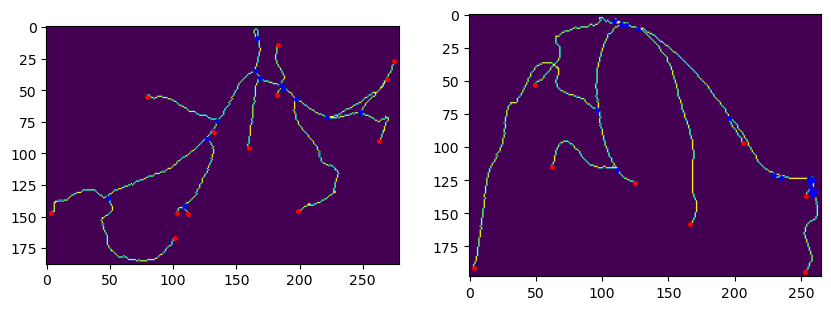

In [756]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(skel_base1.max(axis=2))
plt.plot(bifur1[1],bifur1[0], 'b.', markersize=5)
plt.plot(leafs1[1],leafs1[0], 'r.', markersize=5)
plt.subplot(1,2,2)
plt.imshow(skel_base2.max(axis=2))
plt.plot(bifur2[1],bifur2[0], 'b.', markersize=5)
plt.plot(leafs2[1],leafs2[0], 'r.', markersize=5)

In [762]:
sta

[(slice(0, 188, None), slice(0, 279, None))]

In [758]:
#saving some stuff to check in 3dslicer
tmp = np.zeros(label.shape, dtype=np.int16)
tmp[*bbL]=skel_base1*1
tmp[*bbR]=skel_base2*2

points = np.zeros(label.shape, dtype=np.int16)
for k in keepL:
    points[*bbL][k] = 2
for l in leavesL:
    points[*bbL][l] = 3
for k in keepR:
    points[*bbR][k] = 5
for l in leavesR:
    points[*bbR][l] = 6
    
nrrd.write(f"centerlines_{tip}{nr}.nrrd", tmp, header=headlab)
nrrd.write(f"centerline_points_{tip}{nr}.nrrd", points, header=headlab)

 #### Create tree from skeleton
 ##### (connect the nodes, define which node is the root, check for cycles?)


In [292]:
class SkeletonTree:
    def __init__(self, data):
        self.structure = dict() #node: [children] #for plotting etc, here nodes are represented by xyz tuples
        self.depth = -1
        self.leaves = []
        self.nodes = []
        self.createFromSkel(data)
    
    def createFromSkel(self, skel):
        pass
        

class Node:
    def __init__(self, xyz, parent=None, fvals={'arclen':0, 'radial':0}):
        self.arclen = fvals['arclen']  # Assign the arclen to this point
        self.radial = fvals['radial']  # Assign the radial distance to this pt
        # ...  # Assign more distances, if needed
        self.parent = None
        self.inflow = None #vector(s) of direction(s) where vessels comes into this point
        self.outflow= None #vector(s) of direction(s) where vessels leave the point
        self.xyz = tuple(xyz) #position in 3D, for better viewing
    def __repr__(self):
        return f"Node{self.xyz}   [dist from root: {self.arclen}]"

    
    

In [761]:
aorta_start1 = cc3d.connected_components(skel_base1[...,-1]>500, connectivity=26)
sta = cc3d.statistics(aorta_start1)["bounding_boxes"]
aorta1 = cc3d.connected_components(skel_base1[...,-1]>500, connectivity=26)
#aorta1 = aorta1==aorta1[aorta_start1]

In [721]:
# add root/source as tree node; should be a leaf node, as close as possible to a viable voxel. 
num_leaves1 = len(leafs1[0])
best_for_root1 = np.argmin([np.sum(np.square(viable1-leafs1[:2,x:x+1]),axis=0).min()+(root1-leafs1[2,x:x+1])**2 for x in range(num_leaves1)])
num_leaves2 = len(leafs2[0])
best_for_root2 = np.argmin([np.sum(np.square(viable2-leafs2[:2,x:x+1]),axis=0).min()+(root2-leafs2[2,x:x+1])**2 for x in range(num_leaves2)])
#or: instead of just in z check whats closest to aorta. Due to thickenings, root may not be detected as leaf!


aorta_start1 = cc3d.connected_components(skel_base1[...,-1]>500, connectivity=26)
aorta1 = cc3d.connected_components(skel_base1[...,-1]>500, connectivity=26)
aorta1 = aorta1==aorta1[aorta_start1]
komp=np.nonzero(skel_base)
corner=(0-bbL[0].start, label.shape[1]-bbL[1].start, label.shape[2]-bbL[2].start) #za levo
#corner=(label.shape[0]-bbR[0].start, label.shape[1]-bbR[1].start, label.shape[2]-bbR[2].start) #za desno
best_for_root2= np.argmin(np.square(komp[0] - corner[0])+np.square(komp[1] - corner[1])+np.square(komp[2] - corner[2]))
rootnode2 = tuple(cmp[best_for_root2] for cmp in komp)                                    

nodes_childr = {nd: [] for nd in zip(*leafs)} | {nd: [] for nd in zip(*bifur)}
nodes_dists = {nd: 0 for nd in leaves} | {nd: 0 for nd in keep} #arclen
rootnode = leaves[best_for_root]

to_visit = skel_base.copy().astype(np.uint8)
stack = [(rootnode, 0)]
while stack:
    all_children = get_subtree(stack[0][0], stack[0][1], to_visit, nodes_dists)
    for ch in all_children:
        nodes_dists[ch[0]] = ch[1]
        nodes_childr[stack[0][0]].append(ch[0])
        if ch[0] not in leaves: #avoid calling on leaves
            stack.append(ch)
    stack = stack[1:]
    
    


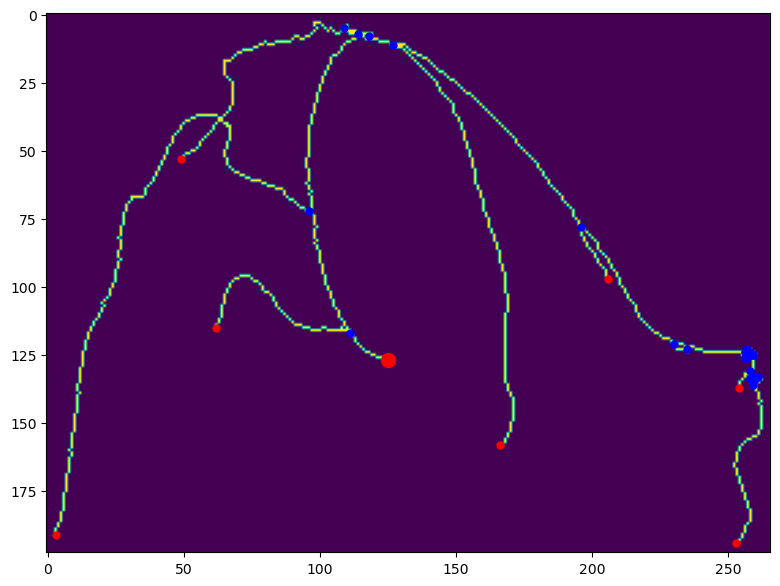

In [724]:
problems=[[116,106],[90,155]]
plt.figure(figsize=(10,7))
plt.imshow(skel_base.max(axis=2))

plt.plot(bifur[1],bifur[0], 'b.', markersize=10)
plt.plot(leafs[1],leafs[0], 'r.', markersize=10)
plt.plot(rootnode[1], rootnode[0], 'r.', markersize=20)
#plt.plot(problems[1],problems[0], 'g.', markersize=13)


In [421]:
#get connections between a node and its children. calculate arclen as you go
def get_subtree(node, distance, to_visit, nodelist):
    roi = to_visit[node[0]-1:node[0]+2, node[1]-1:node[1]+2, node[2]-1:node[2]+2]
    roi[1,1,1] = 0 
    directions = list(zip(*np.nonzero(roi)))
    to_visit[node[0]-1:node[0]+2, node[1]-1:node[1]+2, node[2]-1:node[2]+2] = 0 #all directions are set to 0
    
    children = []
    for dirx in directions:        
        current_node = tuple(i+j-1 for i,j in zip(dirx, node)) #node we're at at the moment
        dist = distance+1
        
        while current_node not in nodelist: #not bifur, nor leaf
            subroi = to_visit[current_node[0]-1:current_node[0]+2, current_node[1]-1:current_node[1]+2, current_node[2]-1:current_node[2]+2]
            subroi[1,1,1] = 0 #cant stay on the same pixel
            #all possible directions from here:
            dirs = list(tuple(i+j-1 for i,j in zip(current_node, one_dir)) for one_dir in zip(*np.nonzero(subroi)))
            if len(dirs)==0:
                print("Problem: reached a leaf not marked as leaf, at ", current_node)
                print("\t adding to children...")
                break
            elif len(dirs)>1:
                print("Problem: more then one direction, but not marked as bifurcation, at ", current_node)
                print("\t ignoring all but first direction...")
            to_visit[*current_node] = 0 #the current_node has been visited, and is not bifur/leaf, so tick it off. 
            current_node = dirs[0] #choose next node to move to
            dist += 1
                  
        children.append((current_node, dist))

    return children

#TODO: actually going from leaves up would probably help you avoid many issues. 

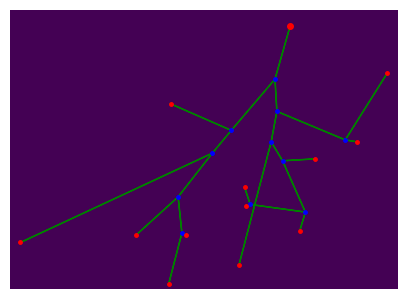

In [679]:
plt.figure(figsize=(5,5))
plt.imshow(skel_base.max(axis=2)*0)

plt.plot(bifur[1],bifur[0], 'b.', markersize=5)
plt.plot(leafs[1],leafs[0], 'r.', markersize=5)
plt.plot(rootnode[1],rootnode[0], 'r.', markersize=8)
for nd in nodes_childr:
    for fd in nodes_childr[nd]:
        plt.arrow(nd[1],nd[0], fd[1]-nd[1], fd[0]-nd[0], width=0.1,  ec='green') #head_width=5,
plt.axis("off")
plt.savefig("vesselgraph")

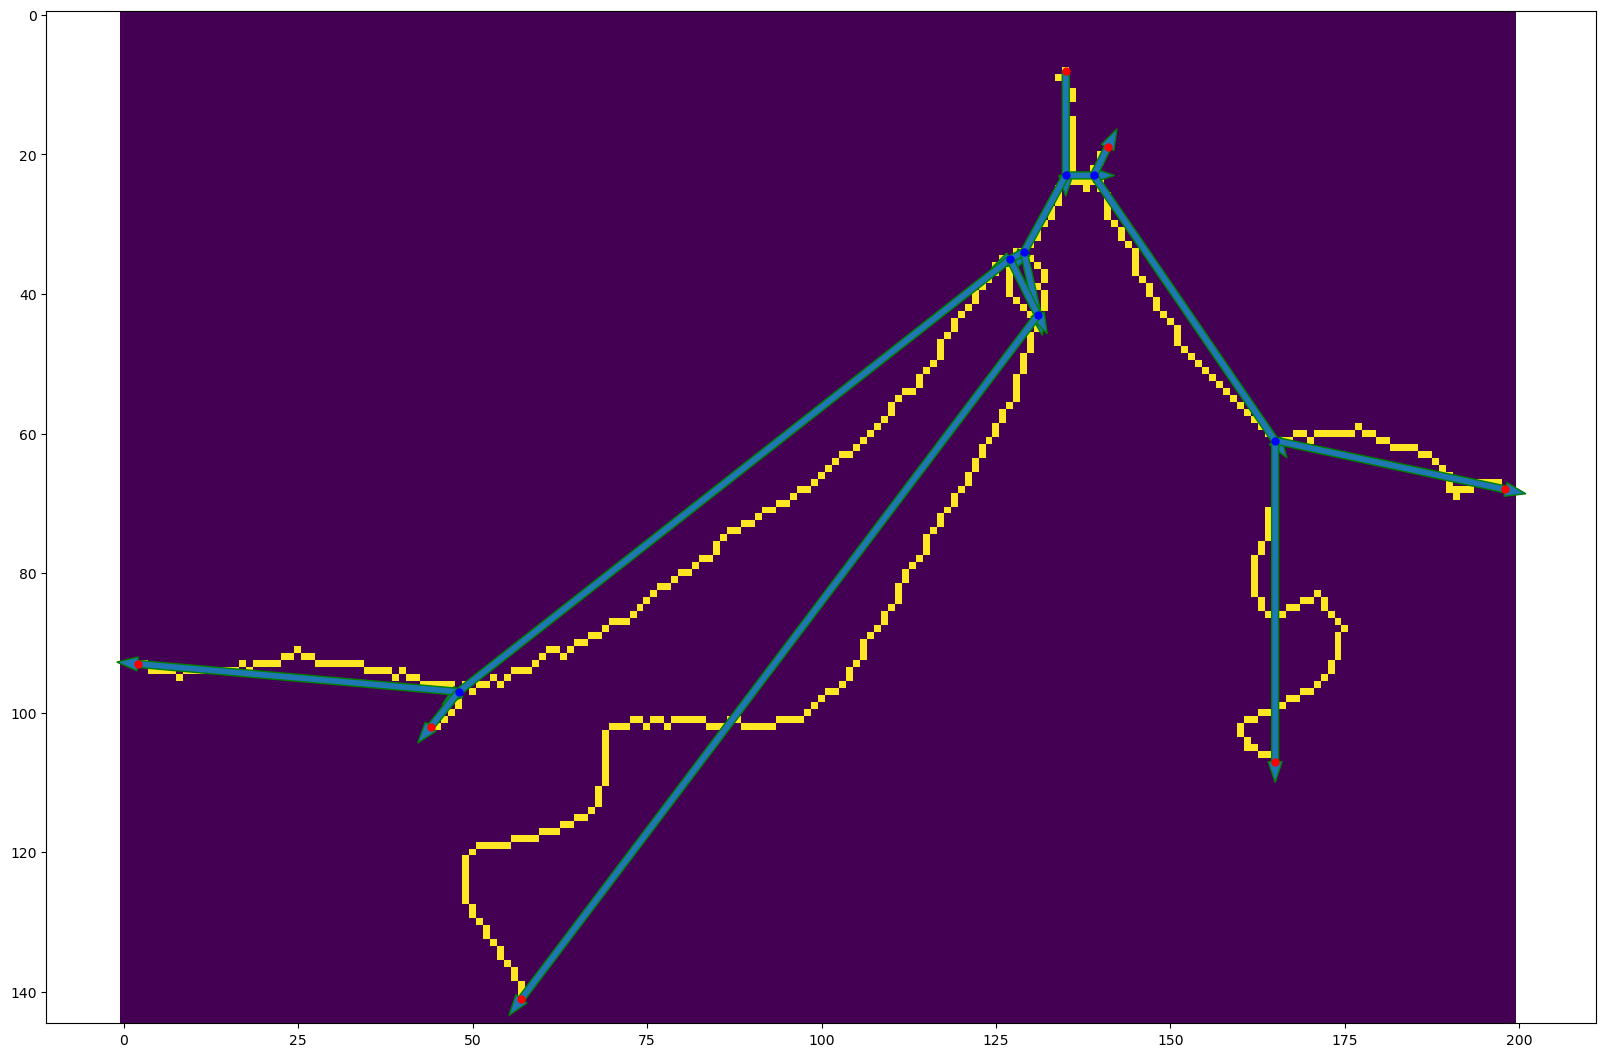

In [424]:
plt.figure(figsize=(20,20))
plt.imshow(skel_base.max(axis=2))

plt.plot(bifur[1],bifur[0], 'b.', markersize=10)
plt.plot(leafs[1],leafs[0], 'r.', markersize=10)
for nd in nodes_childr:
    for fd in nodes_childr[nd]:
        plt.arrow(nd[1],nd[0], fd[1]-nd[1], fd[0]-nd[0], width=1, head_width=2, ec='green') #head_width=5,

### 2. run algo:

In [475]:
def TMD(tree, func, root): #does not work. Just an idea of how things could work if object oriented impl. po graph
    pers_barcode = []
    active = []
    v = dict()
    for leaf in leaves:
        active.append(leaf)
        #pers_barcode.append((func(leaf), func(leaf)))
        v[leaf] = func[leaf]
        
    while root not in active:
        for node in active:
            parents = node.parent()
            for parent in parents:
                children = parent.children()
                if np.all([ch in active for c in children]):
                    for pp in parents:
                        active.append(pp)
                    cm = np.argmax([func(ch) for ch in children])
                    for ch in children:
                        if ch!=cm:
                            pers_barcode.append((v(ch), func(ch)))
                        del active[ch]
                    v[parent] = v[cm]
    return pers_barcode


#easier impl of TMD, based on the data structures I use in tree building:
def getTMD(nodes_childr, func):
    persist = []
    rootnode = (None,None,None)
    v = dict() #stores v values, but also keeps track of what's been "done"
    nr_done = 0
    Nn = len(nodes_childr)
    
    while nr_done!=Nn:
        for node, node_chs in nodes_childr.items():
            if node in v: 
                #already been done; all its children have been processed
                continue
            rootnode = node #the last node we visit altogether should be the root. 
            if len(node_chs)==0:
                #leaf node
                v[node] = func[node]
                nr_done+=1
            elif np.all([c in v for c in node_chs]): #all children already have assigned v. This is True even when at leaf nodes. 
                nr_done+=1 #node is being done now too. (Done = assigned v value.) 
                tmp = [v[c] for c in node_chs]
                best = np.argmax(tmp)
                v[node] = tmp[best]
                for i in range(len(tmp)):
                    if i!=best:
                        persist.append((tmp[i], func[node]))
    #add also root/main comp                    
    persist.append((v[rootnode], func[rootnode]))
    print("got to rootnode", rootnode)
    print(v)
    return persist

In [476]:
getTMD(nodes_childr, nodes_dists)

got to rootnode (8, 135, 58)
{(19, 141, 53): 26, (68, 198, 1): 111, (93, 2, 7): 161, (102, 44, 25): 121, (107, 165, 12): 127, (141, 57, 5): 173, (43, 131, 57): 173, (61, 165, 35): 127, (97, 48, 31): 161, (23, 139, 53): 127, (35, 127, 59): 173, (34, 129, 59): 173, (23, 135, 60): 173, (8, 135, 58): 173}


[(111, 61), (121, 115), (26, 22), (161, 28), (173, 26), (127, 15), (173, 0)]

In [477]:
tmd = getTMD(nodes_childr, nodes_dists)


got to rootnode (8, 135, 58)
{(19, 141, 53): 26, (68, 198, 1): 111, (93, 2, 7): 161, (102, 44, 25): 121, (107, 165, 12): 127, (141, 57, 5): 173, (43, 131, 57): 173, (61, 165, 35): 127, (97, 48, 31): 161, (23, 139, 53): 127, (35, 127, 59): 173, (34, 129, 59): 173, (23, 135, 60): 173, (8, 135, 58): 173}


In [471]:
nodes_childr

{(8, 135, 58): [(23, 135, 60)],
 (19, 141, 53): [],
 (68, 198, 1): [],
 (93, 2, 7): [],
 (102, 44, 25): [],
 (107, 165, 12): [],
 (141, 57, 5): [],
 (23, 135, 60): [(34, 129, 59), (23, 139, 53)],
 (23, 139, 53): [(19, 141, 53), (61, 165, 35)],
 (34, 129, 59): [(35, 127, 59), (43, 131, 57)],
 (35, 127, 59): [(97, 48, 31), (43, 131, 57)],
 (43, 131, 57): [(141, 57, 5)],
 (61, 165, 35): [(68, 198, 1), (107, 165, 12)],
 (97, 48, 31): [(93, 2, 7), (102, 44, 25)]}

In [472]:
nodes_dists

{(8, 135, 58): 0,
 (19, 141, 53): 26,
 (68, 198, 1): 111,
 (93, 2, 7): 161,
 (102, 44, 25): 121,
 (107, 165, 12): 127,
 (141, 57, 5): 173,
 (23, 135, 60): 15,
 (23, 139, 53): 22,
 (34, 129, 59): 26,
 (35, 127, 59): 28,
 (43, 131, 57): 37,
 (61, 165, 35): 61,
 (97, 48, 31): 115}

In [482]:
def plotBarcode(tuple_list):
    plt.figure()
    for bar in tuple_list:
        plt.line(bar)
    plt.show()

def plotPersDiagram(tuple_list):
    stk = np.stack(tuple_list)
    mm = stk.max()
    plt.figure()
    plt.plot(stk[:,1], stk[:,0], 'r.', markersize=8)
    plt.xlim(-1,mm+5)
    plt.ylim(0,mm+5)
    plt.plot(np.arange(0,mm+5),np.arange(0,mm+5), 'k-')

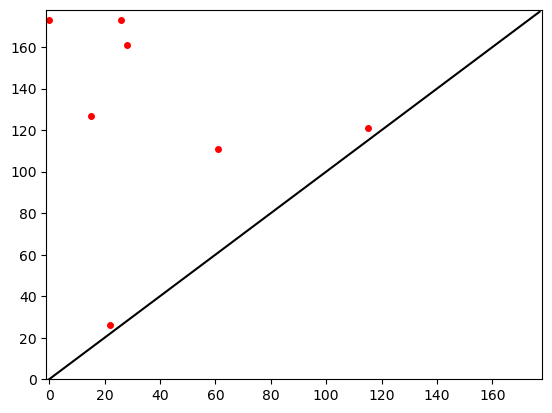

In [483]:
plotPersDiagram(tmd)

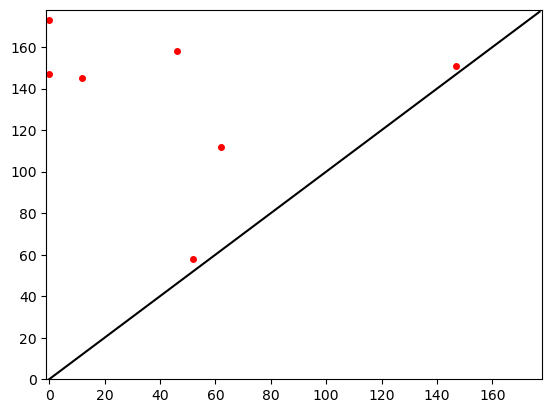

In [488]:
stk = np.stack(tmd)
mm = stk.max()
plt.figure()
plt.plot(mm-stk[:,0], mm-stk[:,1], 'r.', markersize=8)
plt.xlim(-1,mm+5)
plt.ylim(0,mm+5)
plt.plot(np.arange(0,mm+5),np.arange(0,mm+5), 'k-')

In [649]:
mm

173

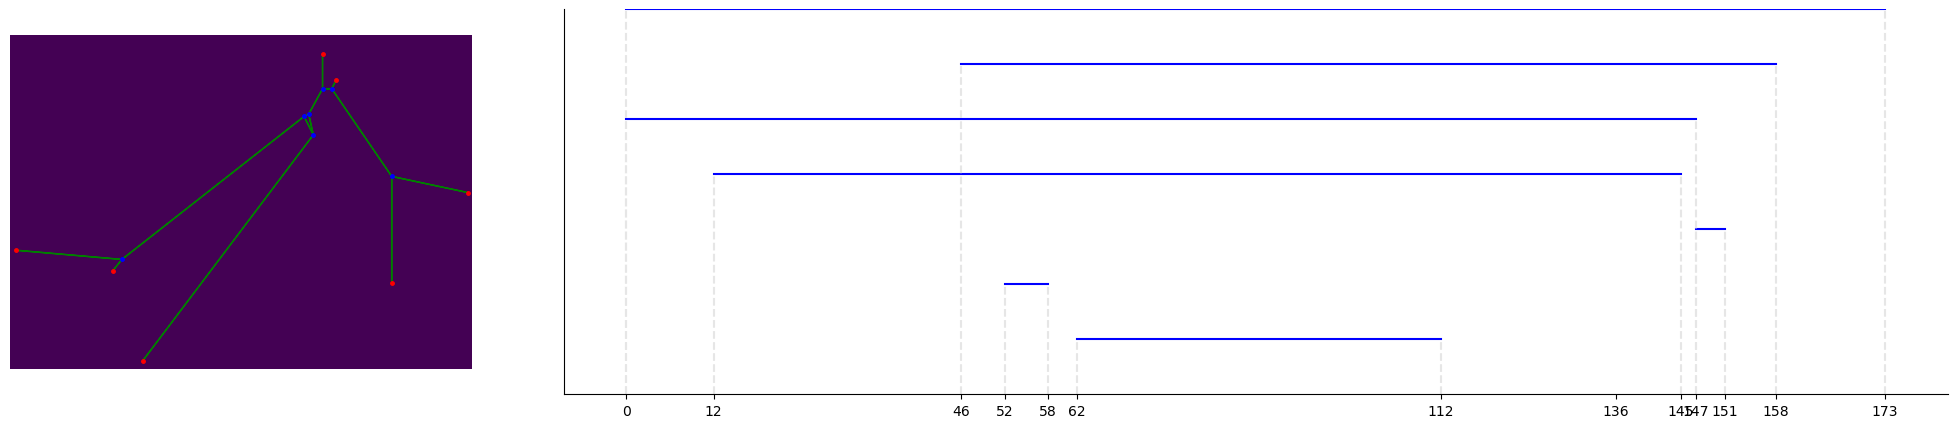

In [522]:
from matplotlib import gridspec
fig=plt.figure(figsize=(25,5))
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         width_ratios=[1, 3], wspace=0.1,
                         hspace=0.01) #, height_ratios=[2, 1])
ax0 = fig.add_subplot(spec[0])
#plt.subplot(2,1,1)
ax0.imshow(skel_base.max(axis=2)*0)

ax0.plot(bifur[1],bifur[0], 'b.', markersize=5)
ax0.plot(leafs[1],leafs[0], 'r.', markersize=5)
for nd in nodes_childr:
    for fd in nodes_childr[nd]:
        ax0.arrow(nd[1],nd[0], fd[1]-nd[1], fd[0]-nd[0], width=0.1,  ec='green') #head_width=5,
ax0.axis("off")

#ax=plt.subplot(2,1,2)
#mm = 173, ie max of all in pers.diag
ax1 = fig.add_subplot(spec[1])
for idx,i in enumerate(tmd):
    ax1.plot([mm-i[0],mm-i[1]],[idx+1,idx+1], 'b-')
    ax1.plot([mm-i[0],mm-i[0]], [0,idx+1], '--', color="0.9")
    ax1.plot([mm-i[1],mm-i[1]], [0,idx+1], '--', color="0.9")
    
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.xticks([0,12, 46, 52, 58, 62,112, 136, 145, 147, 151, 158, 173],[0,12, 46, 52, 58, 62,112, 136, 145, 147, 151, 158, 173]) # [173,161,127,121,115,111,61,37,28,26,22,15,0])
plt.yticks([])
plt.ylim(0,7)

plt.savefig("vesselgraph_barcode")

7

### 3. Try TMD 
##### Try TMD on all images, both trees. Check to see any pattern/clustering?

In [689]:
from pathlib import Path
import pickle

pot = Path("/home/maia-user/Desktop/nnUNet_raw/Dataset666_ASOCA/labelsTr")

all_diagrams_arclen = dict()
all_diagrams_radial = dict()
debug = 5
cnt = 0
for imgpot in pot.glob("*.nrrd"):
    cnt+=1
    if cnt==debug:
        break
    #get label img
    label, headlab = nrrd.read(imgpot)
    print(imgpot.name)
    all_diagrams_arclen[imgpot.name] = []
    all_diagrams_radial[imgpot.name] = []
    CCdict = getCCinfo(label)
    
    #now analyze each branch
    for side in ['left', 'right']:
        print(f"\t side: {side}")
        vessel = CCdict[side][-1]
        #skeletonize and get branch points
        skel_base = skeletonize(vessel)
        splitz, leafz, best_root_candidate = getBranchPoints(skel_base)

        nodes_childr = {nd: [] for nd in leafz} | {nd: [] for nd in splitz}
        nodes_dists = {nd: 0 for nd in leafz} | {nd: 0 for nd in splitz} #arclen
        rootnode = leafz[best_root_candidate]

        #build a graph
        to_visit = skel_base.copy().astype(np.uint8)
        stack = [(rootnode, 0)]
        while stack:
            all_children = get_subtree(stack[0][0], stack[0][1], to_visit, nodes_dists)
            for ch in all_children:
                nodes_dists[ch[0]] = ch[1]
                nodes_childr[stack[0][0]].append(ch[0])
                if ch[0] not in leaves: #avoid calling on leaves
                    stack.append(ch)
            stack = stack[1:]
        del stack, to_visit
        #now the stack is empty, tree is ready
        #OPTIONAL: for running with radial distance, compute even that:
        nodes_radial = {nd: sum([(ndi-rooti)**2 for ndi, rooti in zip(nd, rootnode)]) for nd in nodes_dists} 
        # run TMD!
        print("\t running TMD...")
        persist_vec, assert_root = getTMD(nodes_childr, nodes_dists)
        assert assert_root==rootnode, (assert_root, rootnode)
        persist_vec_rad, assert_root_rad = getTMD(nodes_childr, nodes_radial)
        assert assert_root_rad==rootnode, (assert_root_rad, rootnode)

        #TODO: various ways to calc distance between persistence vectors of this kind/pers.diagrams. 
        #TODO: save persistence diags for each image (both sides) to some reasonable format
        #TODO: cluster per.diags, to see if you can detect coronary dominance 
        all_diagrams_arclen[imgpot.name].append(persist_vec)
        all_diagrams_radial[imgpot.name].append(persist_vec_rad)
            
#save the dicts 
with open('pers_vecs_arclen.pkl', 'wb') as fp:
    pickle.dump(all_diagrams_arclen, fp)
with open('pers_vecs_radial.pkl', 'wb') as fp:
    pickle.dump(all_diagrams_radial, fp)            
                

Diseased_4.nrrd
	 side: left
running TMD...
	 side: right
running TMD...
Diseased_17.nrrd
	 side: left
running TMD...
	 side: right
running TMD...
Normal_11.nrrd
	 side: left
running TMD...


KeyboardInterrupt: 

In [544]:
#now cluster/check differences based on heatlhy/diseased, or general clustering of l-r pairs to two classes;
#maybe it finds different dominance. Otherwise, can ti discern between left and right?

In [648]:
all_diagrams_arclen

{'Diseased_4.nrrd': [[(169, 89),
   (138, 134),
   (137, 53),
   (72, 47),
   (138, 7),
   (194, 0)],
  [(248, 244),
   (199, 195),
   (212, 171),
   (171, 168),
   (107, 102),
   (73, 72),
   (143, 61),
   (28, 24),
   (281, 0)]],
 'Diseased_17.nrrd': [[(156, 84),
   (205, 203),
   (129, 116),
   (123, 121),
   (197, 72),
   (127, 101),
   (170, 61),
   (183, 70),
   (167, 45),
   (91, 58),
   (201, 28),
   (212, 0)],
  [(114, 96), (236, 228), (117, 79), (124, 37), (257, 0)]]}

In [683]:
diagrama

'Diseased_4.nrrd'

In [ ]:
#TODO: order by length or start?
plt.figure()
distance = all_diagrams_radial
mm=256
N=len(distance)
n=0
for subj in distance:
    n+=1
    diagrama = distance[subj]
    #normalize lengths such that the longest component is always 256 long. 
    maxi = max([di[0] for di in diagrama[0]]+[di[1] for di in diagrama[0]]+[di[0] for di in diagrama[1]]+[di[1] for di in diagrama[1]])
    #plot both left and right on same graph. 
    plt.subplot(1,N,n)
    for idx,i in enumerate(diagrama[0]):
        plt.plot([mm-i[0]*(mm/maxi),mm-i[1]*(mm/maxi)],[idx+1,idx+1], 'b-')
        plt.plot([mm-i[0]*(mm/maxi),mm-i[0]*(mm/maxi)], [0,idx+1], '--', color="0.9")
        plt.plot([mm-i[1]*(mm/maxi),mm-i[1]*(mm/maxi)], [0,idx+1], '--', color="0.9")
    offset=idx+1
    for idx2,i in enumerate(diagrama[1]):
        idx = idx2+offset
        plt.plot([mm-i[0]*(mm/maxi),mm-i[1]*(mm/maxi)],[idx+1,idx+1], 'r-')
        plt.plot([mm-i[0]*(mm/maxi),mm-i[0]*(mm/maxi)], [0,idx+1], '--', color="0.9")
        plt.plot([mm-i[1]*(mm/maxi),mm-i[1]*(mm/maxi)], [0,idx+1], '--', color="0.9")
        

In [688]:
def getCCinfo(label):
    labels_out, N = cc3d.connected_components(label, connectivity=26, return_N=True)
    stats = cc3d.statistics(labels_out)
    mainCCs = np.argsort(stats['voxel_counts'])[-3:-1]
    # Now you have the indices of two main vascular CCs. 
    # The first one is smaller in size than the second one, by construction.
    # Which is left, which is right:
    cc1 = stats['bounding_boxes'][mainCCs[0]]
    cc2 = stats['bounding_boxes'][mainCCs[1]]
    if cc1[0].start>cc2[0].start:
        L, R = mainCCs[0], mainCCs[1]
      #  Lroot, Rroot = cc1[2].stop, cc2[2].stop
        bbL, bbR = cc1, cc2
    else:
        L, R = mainCCs[1], mainCCs[0]
      #  Lroot, Rroot = cc2[2].stop, cc1[2].stop
        bbL, bbR = cc2, cc1
    
    # for faster processing, cut the image to bounding box+1. 
    bbL = tuple(slice(max(ind.start-1, 0),  min(ind.stop+1, s), None) for ind, s in zip(bbL, label.shape))
    bbR = tuple(slice(max(ind.start-1, 0),  min(ind.stop+1, s), None) for ind, s in zip(bbR, label.shape))
    
    CCdict = {'left': (bbL, stats['voxel_counts'][L], labels_out[*bbL]==L), 'right': (bbR, stats['voxel_counts'][R], labels_out[*bbR]==R)}
    return CCdict


def getBranchPoints(skel_base):
    #get root 
    root = skel_base.shape[2]-1
    while not skel_base[:,:,root].any():
        root-=1
    viable = np.nonzero(skel_base[:,:,root])
  #  if len(viable[0])>1:
  #      print("More than one candidate for root!")
    viable = np.stack(viable)

    weights = cube(3)
    #neighbors = correlate(skel_base*1, weights, mode='constant')
    leaves, bifur = [], []
    start = time.time()
    for x,y,z in zip(*np.nonzero(skel_base)):
        num_ngbhs = skel_base[x-1:x+2, y-1:y+2, z-1:z+2].sum()
        if num_ngbhs==2:
            leaves.append((x,y,z))
        elif num_ngbhs>3:
            bifur.append((x,y,z))
    
    # remove those bifurcation points that neighbor on bifurcation points; keep only the one with highest degree. 
    # some things will be done repeatedly but not really a problem here, since we have a low amount of bifurcations;
    keep = []
    SE = ball(1)
    for i,j,k in bifur:
        possible = [(sh_i, sh_j, sh_k) for sh_i in range(0,3) for sh_j in range(0,3) for sh_k in range(0,3) if (i+sh_i-1, j+sh_j-1, k+sh_k-1) in bifur]
        # now take the weight center and keep that as the only valid bifurcation of this group
        if len(possible)==1:
            keep.append((i,j,k))
        else: #we need to keep only one of them
            tmp = np.zeros((3,3,3))
            tmp[*zip(*possible)] = 1
            #now we have a 3x3x3 cube with 1 with neighbor bifur constellation
            #we take the one that has most direct neighbors. (by faces)
            idx = np.argmax(tmp*correlate(tmp, SE, mode='constant'))
            offi, offj, offk = idx//9, idx//3-(idx//9)*3, idx%3
            tokeep = (i+offi-1, j+offj-1, k+offk-1)
            if tokeep not in keep:
                keep.append(tokeep)
            assert tokeep in bifur, [tokeep, bifur]

    #find also best candidate for root
    leafs = np.stack(leaves).T
    num_leaves = len(leaves)
    best_for_root = np.argmin([np.sum(np.square(viable-leafs[:2,x:x+1]),axis=0).min()+(root-leafs[2,x:x+1])**2 for x in range(num_leaves)])
    
    return keep, leaves, best_for_root

#bifur = np.stack(keep).T
#leafs = np.stack(leaves).T


#get connections between a node and its children. calculate arclen as you go
def get_subtree(node, distance, to_visit, nodelist):
    roi = to_visit[node[0]-1:node[0]+2, node[1]-1:node[1]+2, node[2]-1:node[2]+2]
    roi[1,1,1] = 0 
    directions = list(zip(*np.nonzero(roi)))
    to_visit[node[0]-1:node[0]+2, node[1]-1:node[1]+2, node[2]-1:node[2]+2] = 0 #all directions are set to 0
    
    children = []
    for dirx in directions:        
        current_node = tuple(i+j-1 for i,j in zip(dirx, node)) #node we're at at the moment
        dist = distance+1
        
        while current_node not in nodelist: #not bifur, nor leaf
            subroi = to_visit[current_node[0]-1:current_node[0]+2, current_node[1]-1:current_node[1]+2, current_node[2]-1:current_node[2]+2]
            subroi[1,1,1] = 0 #cant stay on the same pixel
            #all possible directions from here:
            dirs = list(tuple(i+j-1 for i,j in zip(current_node, one_dir)) for one_dir in zip(*np.nonzero(subroi)))
            if len(dirs)==0:
                break
            to_visit[*current_node] = 0 #the current_node has been visited, and is not bifur/leaf, so tick it off. 
            current_node = dirs[0] #choose next node to move to
            dist += 1
                  
        children.append((current_node, dist))
    return children


#easier impl of TMD, based on the data structures I use in tree building:
def getTMD(nodes_childr, func):
    persist = []
    rootnode = (None,None,None)
    v = dict() #stores v values, but also keeps track of what's been "done"
    nr_done = 0
    Nn = len(nodes_childr)
    
    while nr_done!=Nn:
        for node, node_chs in nodes_childr.items():
            if node in v: 
                #already been done; all its children have been processed
                continue
            rootnode = node #the last node we visit altogether should be the root. 
            if len(node_chs)==0:
                #leaf node
                v[node] = func[node]
                nr_done+=1
            elif np.all([c in v for c in node_chs]): #all children already have assigned v. This is True even when at leaf nodes. 
                nr_done+=1 #node is being done now too. (Done = assigned v value.) 
                tmp = [v[c] for c in node_chs]
                best = np.argmax(tmp)
                v[node] = tmp[best]
                for i in range(len(tmp)):
                    if i!=best:
                        persist.append((tmp[i], func[node]))
    #add also root/main comp                    
    persist.append((v[rootnode], func[rootnode]))
  #  print("got to rootnode", rootnode)
  #  print(v)
    return persist, rootnode